In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom scripts
from spearman_model import get_spearman_predictions
from utils.formatter import format_to_tuple
from utils.data_processing import z_score
from utils.dataframe_manipulator import parallelize_dataframe_operation

This notebook takes single cell data that have be partially labeled and guesses the unknown labels of other cells by finding their nearest neighbors based on the spearman correlation values calculated on the entire transcriptome. 

In this instance, T-cells were pre-labeled as alpha/beta or gamma/delta based on their expression of T-cell receptor genes TRAC, TRBC, TRDC, TRGC. However due to issues of technical noise and dropout of singe cell sequencing, some cells were initially classified as NA (have 0 read counts for either group of genes) or DP (having more than 1 read counts for both group genes). We correct these labels by finding their nearest correlated cells from the cells that have been labeled as either alpha/beta or gamma/delta, and then borrow their label. 

In [2]:
save_directory = ''

In [17]:
raw_df = pd.read_csv('matrix.txt', sep='\t')
print(f"Dimensions: {raw_df.shape}")
raw_df.head(3)

Dimensions: (18070, 26349)


,"(CellID: AAACCTGCACCCTATC-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 14, prelim_TCR_label: ab+)","(CellID: AAACCTGCACTTCGAA-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 18, prelim_TCR_label: ab+)","(CellID: AAACCTGCAGTATAAG-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 17, prelim_TCR_label: ab+)","(CellID: AAACCTGGTACACCGC-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 15, prelim_TCR_label: ab+)","(CellID: AAACCTGGTACGCTGC-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 3, prelim_TCR_label: NA)","(CellID: AAACCTGGTAGTAGTA-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 23, prelim_TCR_label: NA)","(CellID: AAACCTGGTATAATGG-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 18, prelim_TCR_label: ab+)","(CellID: AAACCTGGTCAGATAA-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 2, prelim_TCR_label: ab+)","(CellID: AAACCTGTCTACCTGC-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 7, prelim_TCR_label: ab+)","(CellID: AAACGGGAGACTAGGC-1_1, ID_masked: Patient_A_1, sample_ID_masked: Patient_A_LAD_LCX, revised_3_phenotypes: Intermediate, seurat_clusters: 1, prelim_TCR_label: ab+)",...,"(CellID: TGGACGCAGAGCTATA.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 25, prelim_TCR_label: ab+)","(CellID: TGGCCAGAGGTGCACA.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 10, prelim_TCR_label: ab+)","(CellID: TGGGAAGTCACCAGGC.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 22, prelim_TCR_label: ab+)","(CellID: TGTCCCAAGACAAAGG.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 17, prelim_TCR_label: ab+)","(CellID: TTCGAAGAGGCTACGA.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 16, prelim_TCR_label: ab+)","(CellID: TTCTACATCTAACCGA.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 12, prelim_TCR_label: ab+)","(CellID: TTGAACGAGGTGCTTT.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 6, prelim_TCR_label: NA)","(CellID: TTTGGTTCAGTCACTA.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 6, prelim_TCR_label: NA)","(CellID: TTTGGTTGTCCATGAT.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 20, prelim_TCR_label: ab+)","(CellID: TTTGGTTGTCGCATAT.7_21, ID_masked: Patient_H_1, sample_ID_masked: Patient_H_RCA, revised_3_phenotypes: Early, seurat_clusters: 7, prelim_TCR_label: ab+)"
RP11-34P13.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FO538757.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Convert column names to tuples
raw_df.columns = map(format_to_tuple, raw_df.columns.tolist())
raw_df = raw_df.T

In [20]:
raw_df['seurat_cluster'] = [int(x[-2].split(': ')[1]) for x in raw_df.index]  
raw_df['cell_ID'] = [x[0].split(': ')[1] for x in raw_df.index]  
raw_df['TCR_type'] = [x[-1].split(': ')[1] for x in raw_df.index]
raw_df = raw_df.assign(order = range(0, raw_df.shape[0]))  # order of cells added
raw_df = raw_df.set_index(['cell_ID', 'order'])
raw_df.head(3)

,,RP11-34P13.7,FO538757.2,AP006222.2,RP11-206L10.9,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,...,RP13-991F5.2,CLEC4G,CTD-2013N17.7,COMP,EHD2,RP3-333H23.8,A4GALT,RP3-402G11.25,seurat_cluster,TCR_type
cell_ID,order,,,,,,,,,,,,,,,,,,,,,
AAACCTGCACCCTATC-1_1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,ab+
AAACCTGCACTTCGAA-1_1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,ab+
AAACCTGCAGTATAAG-1_1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,ab+


# Data preparation

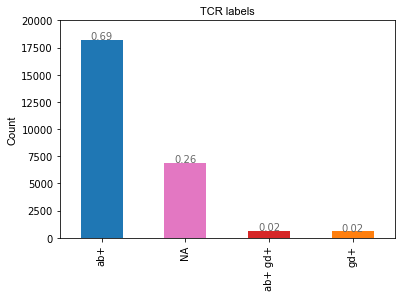

In [12]:
# Summary 
colors = {"ab+": '#1f77b4', 'gd+': '#ff7f0e', 'NA': '#e377c2', 'ab+ gd+': '#d62728'}
tmp = raw_df.TCR_type.value_counts()
ax = tmp.plot(kind='bar', color=[colors[x] for x in tmp.index.to_list()])
ax.set_ylabel('Count', fontsize = 11, fontname= "Arial")
ax.set_title('TCR labels', fontsize = 11, fontname= "Arial")

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, height+50, round(height/raw_df.shape[0], 2), color='dimgrey', ha='center')

ax.set_ylim(ymax=20000)

plt.savefig(save_directory + 'TCR_labels_before_correction.pdf',bbox_inches='tight')
plt.show()

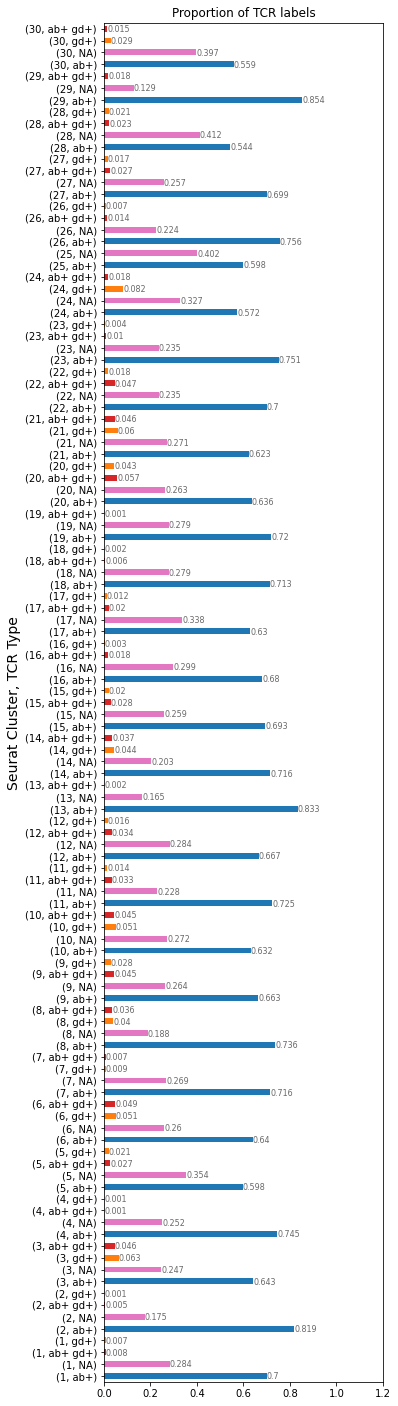

In [16]:
plt.figure(figsize=(5, 25))
tmp = (raw_df.groupby('seurat_cluster').TCR_type.value_counts() / raw_df.groupby('seurat_cluster').size())
ax = tmp.plot(kind='barh', color=[colors[x[1]] for x in tmp.index.to_list()])
ax.set_title('Proportion of TCR labels')
ax.set_ylabel("Seurat Cluster, TCR Type", fontsize=14);

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+i.get_x()/2, 
            i.get_y(),
            str(round(i.get_width(), 3)),
            fontsize=8,
            color='dimgrey')

ax.set_xlim(xmax=1.2)
    
plt.savefig(save_directory + 'proportion_of_TCR_labels_by_cluster.pdf', bbox_inches='tight')
plt.show()

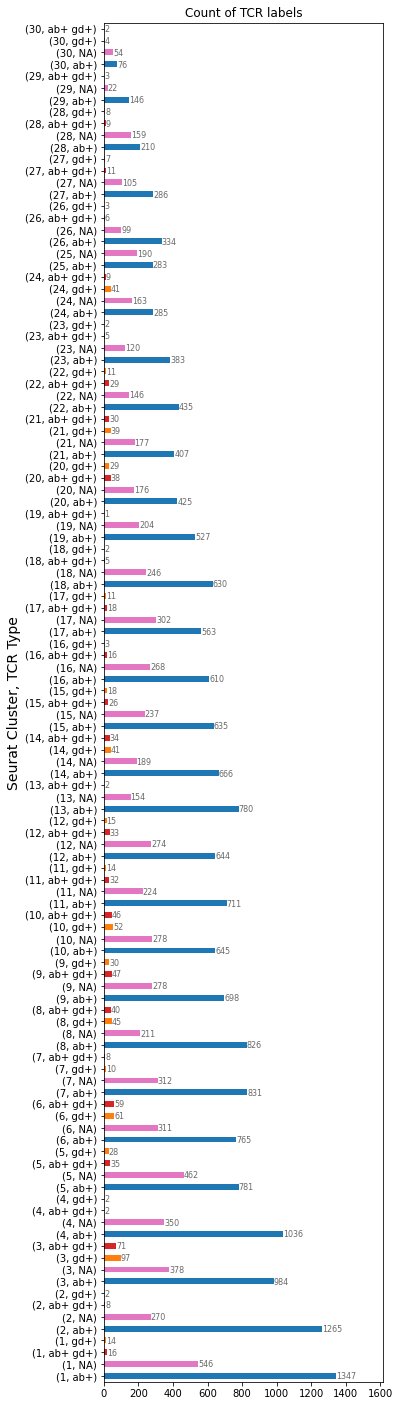

In [17]:
plt.figure(figsize=(5, 25))
tmp = (raw_df.groupby('seurat_cluster').TCR_type.value_counts())
ax = tmp.plot(kind='barh', color=[colors[x[1]] for x in tmp.index.to_list()])
ax.set_title('Count of TCR labels')
ax.set_ylabel("Seurat Cluster, TCR Type", fontsize=14);

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+i.get_x()/2, i.get_y(),
            str(i.get_width()),
            fontsize=8,
            color='dimgrey')
    
ax.set_xlim(xmax=tmp.max() * 1.2)

plt.savefig(save_directory + 'count_of_TCR_labels_by_cluster.pdf', bbox_inches='tight')
plt.show()

In [18]:
# df = raw_df[raw_df.TCR_type != 'ab+ gd+'].copy()  # Remove ambiguous labels 
df = raw_df.copy()
prediction_set = df[df.TCR_type.isin(['NA', 'ab+ gd+'])]
training_set = df[df.TCR_type.isin(['ab+', 'gd+'])]
print('Training set: ', training_set.shape)
print('Prediction set: ', prediction_set.shape)

Training set:  (18803, 18072)
Prediction set:  (7546, 18072)


## Label predictions

In [19]:
X_train_full = training_set.drop("TCR_type", axis=1)
Y_train_full = training_set["TCR_type"]
X_predict = prediction_set.drop("TCR_type", axis=1)

In [20]:
results = []
for i, train_subset in X_train_full.groupby('seurat_cluster'):  # subset training set by cluster 
    print(f"Predicting cluster {i}...")
    pred_subset = X_predict[X_predict['seurat_cluster'] == i] # Subset prediction set by cluster
    if pred_subset.shape[0] > 0:  # edgecase - no cells from specific cluster present 
        if train_subset.shape[0] > 250:
            pred_val = parallelize_dataframe_operation(pred_subset,
                                                       get_spearman_predictions,
                                                       n_cores=8,
                                                       X_train=train_subset,
                                                       Y_train=Y_train_full,
                                                       cluster=None,
                                                       score='mean',
                                                       rm_columns=['seurat_cluster'], 
                                                       top_N=5)
        else:
            pred_val = get_spearman_predictions(pred_subset,
                                                train_subset,
                                                Y_train_full,
                                                cluster=None,
                                                score='mean',
                                                rm_columns=['seurat_cluster'], 
                                                top_N=5)
        results.append(pred_val)
print('DONE')

Predicting cluster 1...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 2...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 3...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 4...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 5...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 6...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 7...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 8...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 9...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 10...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 11...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 12...
Parallelizing get_spearman_predictions on 8 cores...
Predicting cluster 13...
Parallelizing get_spearman_predictions on 8 core

In [17]:
# Add Default label of ab+ for clusters missing in training set
# missing_cluster = X_predict[X_predict['seurat_cluster'] == 14]
# missing_cluster = missing_cluster.assign(labels = 'ab+')
# missing_cluster_labels = pd.Series(missing_cluster.labels.tolist())
# missing_cluster_labels.index = missing_cluster.index
# results.append(missing_cluster_labels)

In [21]:
result_labels = pd.concat(results)
result_labels.name = "Spearman_TCR_labels"
print(result_labels.shape)
result_labels.head()

(7546,)


cell_ID               order
AAACGGGCAGACGCTC-1_1  10       ab+
AACACGTTCTCGTTTA-1_1  45       ab+
AATCCAGTCACATACG-1_1  131      ab+
ACATCAGGTTGGTGGA-1_1  165      ab+
ACGGAGATCAGAGCTT-1_1  232      ab+
Name: Spearman_TCR_labels, dtype: object

In [22]:
result_labels.value_counts()

ab+    7357
gd+     189
Name: Spearman_TCR_labels, dtype: int64

In [15]:
result_labels = result_labels.replace({'Tie': 'ab+'})  # Use major label to replace ties

In [23]:
result_labels.value_counts()

ab+    7357
gd+     189
Name: Spearman_TCR_labels, dtype: int64

In [25]:
new_labels = pd.concat([Y_train_full, result_labels])
new_labels.name = "Spearman_TCR_label"
print(new_labels.shape)
new_labels.head()

(26349,)


cell_ID               order
AAACCTGCACCCTATC-1_1  0        ab+
AAACCTGCACTTCGAA-1_1  1        ab+
AAACCTGCAGTATAAG-1_1  2        ab+
AAACCTGGTACACCGC-1_1  3        ab+
AAACCTGGTATAATGG-1_1  6        ab+
Name: Spearman_TCR_label, dtype: object

In [26]:
new_labels = raw_df.join(new_labels)
new_labels.head()

,,RP11-34P13.7,FO538757.2,AP006222.2,RP11-206L10.9,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,...,CLEC4G,CTD-2013N17.7,COMP,EHD2,RP3-333H23.8,A4GALT,RP3-402G11.25,seurat_cluster,TCR_type,Spearman_TCR_label
cell_ID,order,,,,,,,,,,,,,,,,,,,,,
AAACCTGCACCCTATC-1_1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,ab+,ab+
AAACCTGCACTTCGAA-1_1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,ab+,ab+
AAACCTGCAGTATAAG-1_1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.098612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,ab+,ab+
AAACCTGGTACACCGC-1_1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,ab+,ab+
AAACCTGGTACGCTGC-1_1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NA,ab+


In [27]:
new_labels[['seurat_cluster', 'TCR_type', 'Spearman_TCR_label']].to_csv(save_directory + 'label_predictions.csv')

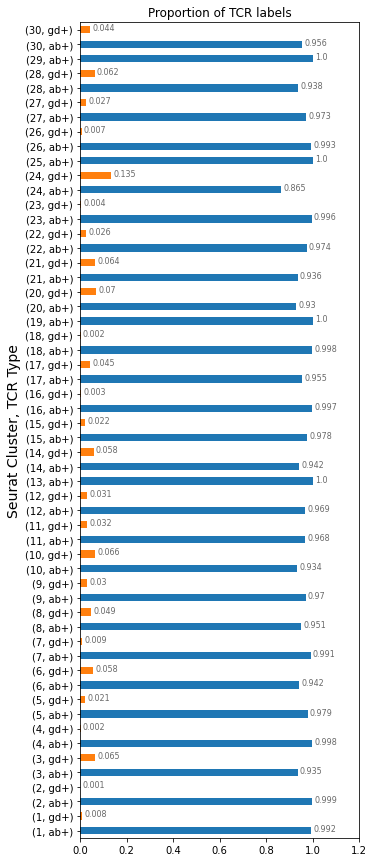

In [30]:
plt.figure(figsize=(5, 15))
tmp = (new_labels.groupby('seurat_cluster').Spearman_TCR_label.value_counts() / raw_df.groupby('seurat_cluster').size())
ax = tmp.plot(kind='barh', color=[colors[x[1]] for x in tmp.index.to_list()])
ax.set_title('Proportion of TCR labels')
ax.set_ylabel("Seurat Cluster, TCR Type", fontsize=14);

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.01, 
            i.get_y() + 0.2,
            str(round(i.get_width(), 3)),
            fontsize=8,
            color='dimgrey')

ax.set_xlim(xmax=1.2)
    
plt.savefig(save_directory + 'proportion_of_TCR_labels_by_cluster_predictions.pdf', bbox_inches='tight')
plt.show()

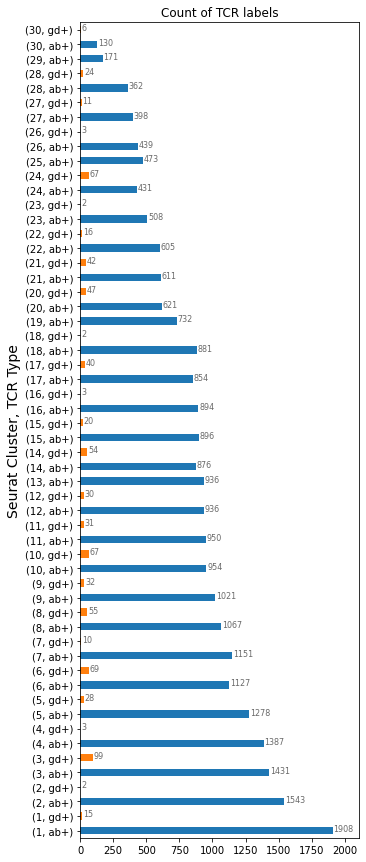

In [31]:
plt.figure(figsize=(5, 15))
tmp = (new_labels.groupby('seurat_cluster').Spearman_TCR_label.value_counts())
ax = tmp.plot(kind='barh', color=[colors[x[1]] for x in tmp.index.to_list()])
ax.set_title('Count of TCR labels')
ax.set_ylabel("Seurat Cluster, TCR Type", fontsize=14);

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+ 5, 
            i.get_y() + 0.2,
            str(i.get_width()),
            fontsize=8,
            color='dimgrey')
    
ax.set_xlim(xmax=tmp.max()+200)

plt.savefig(save_directory + 'count_of_TCR_labels_by_cluster_with_predictions.pdf', bbox_inches='tight')
plt.show()

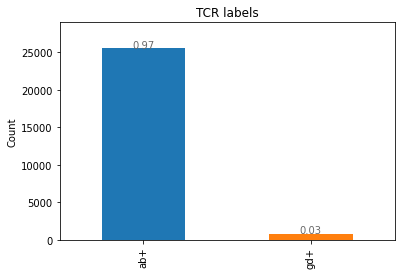

In [35]:
# Summary 
colors = {"ab+": '#1f77b4', 'gd+': '#ff7f0e'}
tmp = new_labels.Spearman_TCR_label.value_counts()
ax = tmp.plot(kind='bar', color=[colors[x] for x in tmp.index.to_list()])
ax.set_ylabel('Count')
ax.set_title('TCR labels')

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, height+50, round(height/raw_df.shape[0], 3), color='dimgrey', ha='center')

ax.set_ylim(ymax = 29000)

plt.savefig(save_directory + 'TCR_labels_after_correction.pdf',bbox_inches='tight')
plt.show()